<a href="https://www.kaggle.com/code/arush0710/image-caption-generator?scriptVersionId=225636382" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

In [3]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [4]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))

    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]

    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [5]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
with open(os.path.join(WORKING_DIR, 'features.pkl'),'rb') as f:
    features = pickle.load(f)

Load the Captions Data

In [7]:
with open(os.path.join(BASE_DIR,'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = "".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(mapping)

8091

In [10]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]','')
            caption = caption.replace('\s+',' ')
            caption = '<start> '+ " ".join([word for word in caption.split() if len(word)>1])+' <end>'
            captions[i] = caption

In [11]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
clean(mapping)

In [13]:
mapping['1000268201_693b08cb0e']

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

40455

In [16]:
all_captions[:10]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>',
 '<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and tri-colored dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> two dogs of different breeds looking at each other on the road <end>',
 '<start> two dogs on pavement moving toward each other <end>']

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
vocab_size

8483

In [19]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

Train Test Split

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids)*0.90)
train = image_ids[:split]
test = image_ids[split:]

In [21]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq],maxlen = max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1,X2, y = np.array(X1),np.array(X2),np.array(y)
                yield {"image":X1, "text":X2},y
                X1, X2, y = list(), list(), list()
                n=0
                    

Model Creation

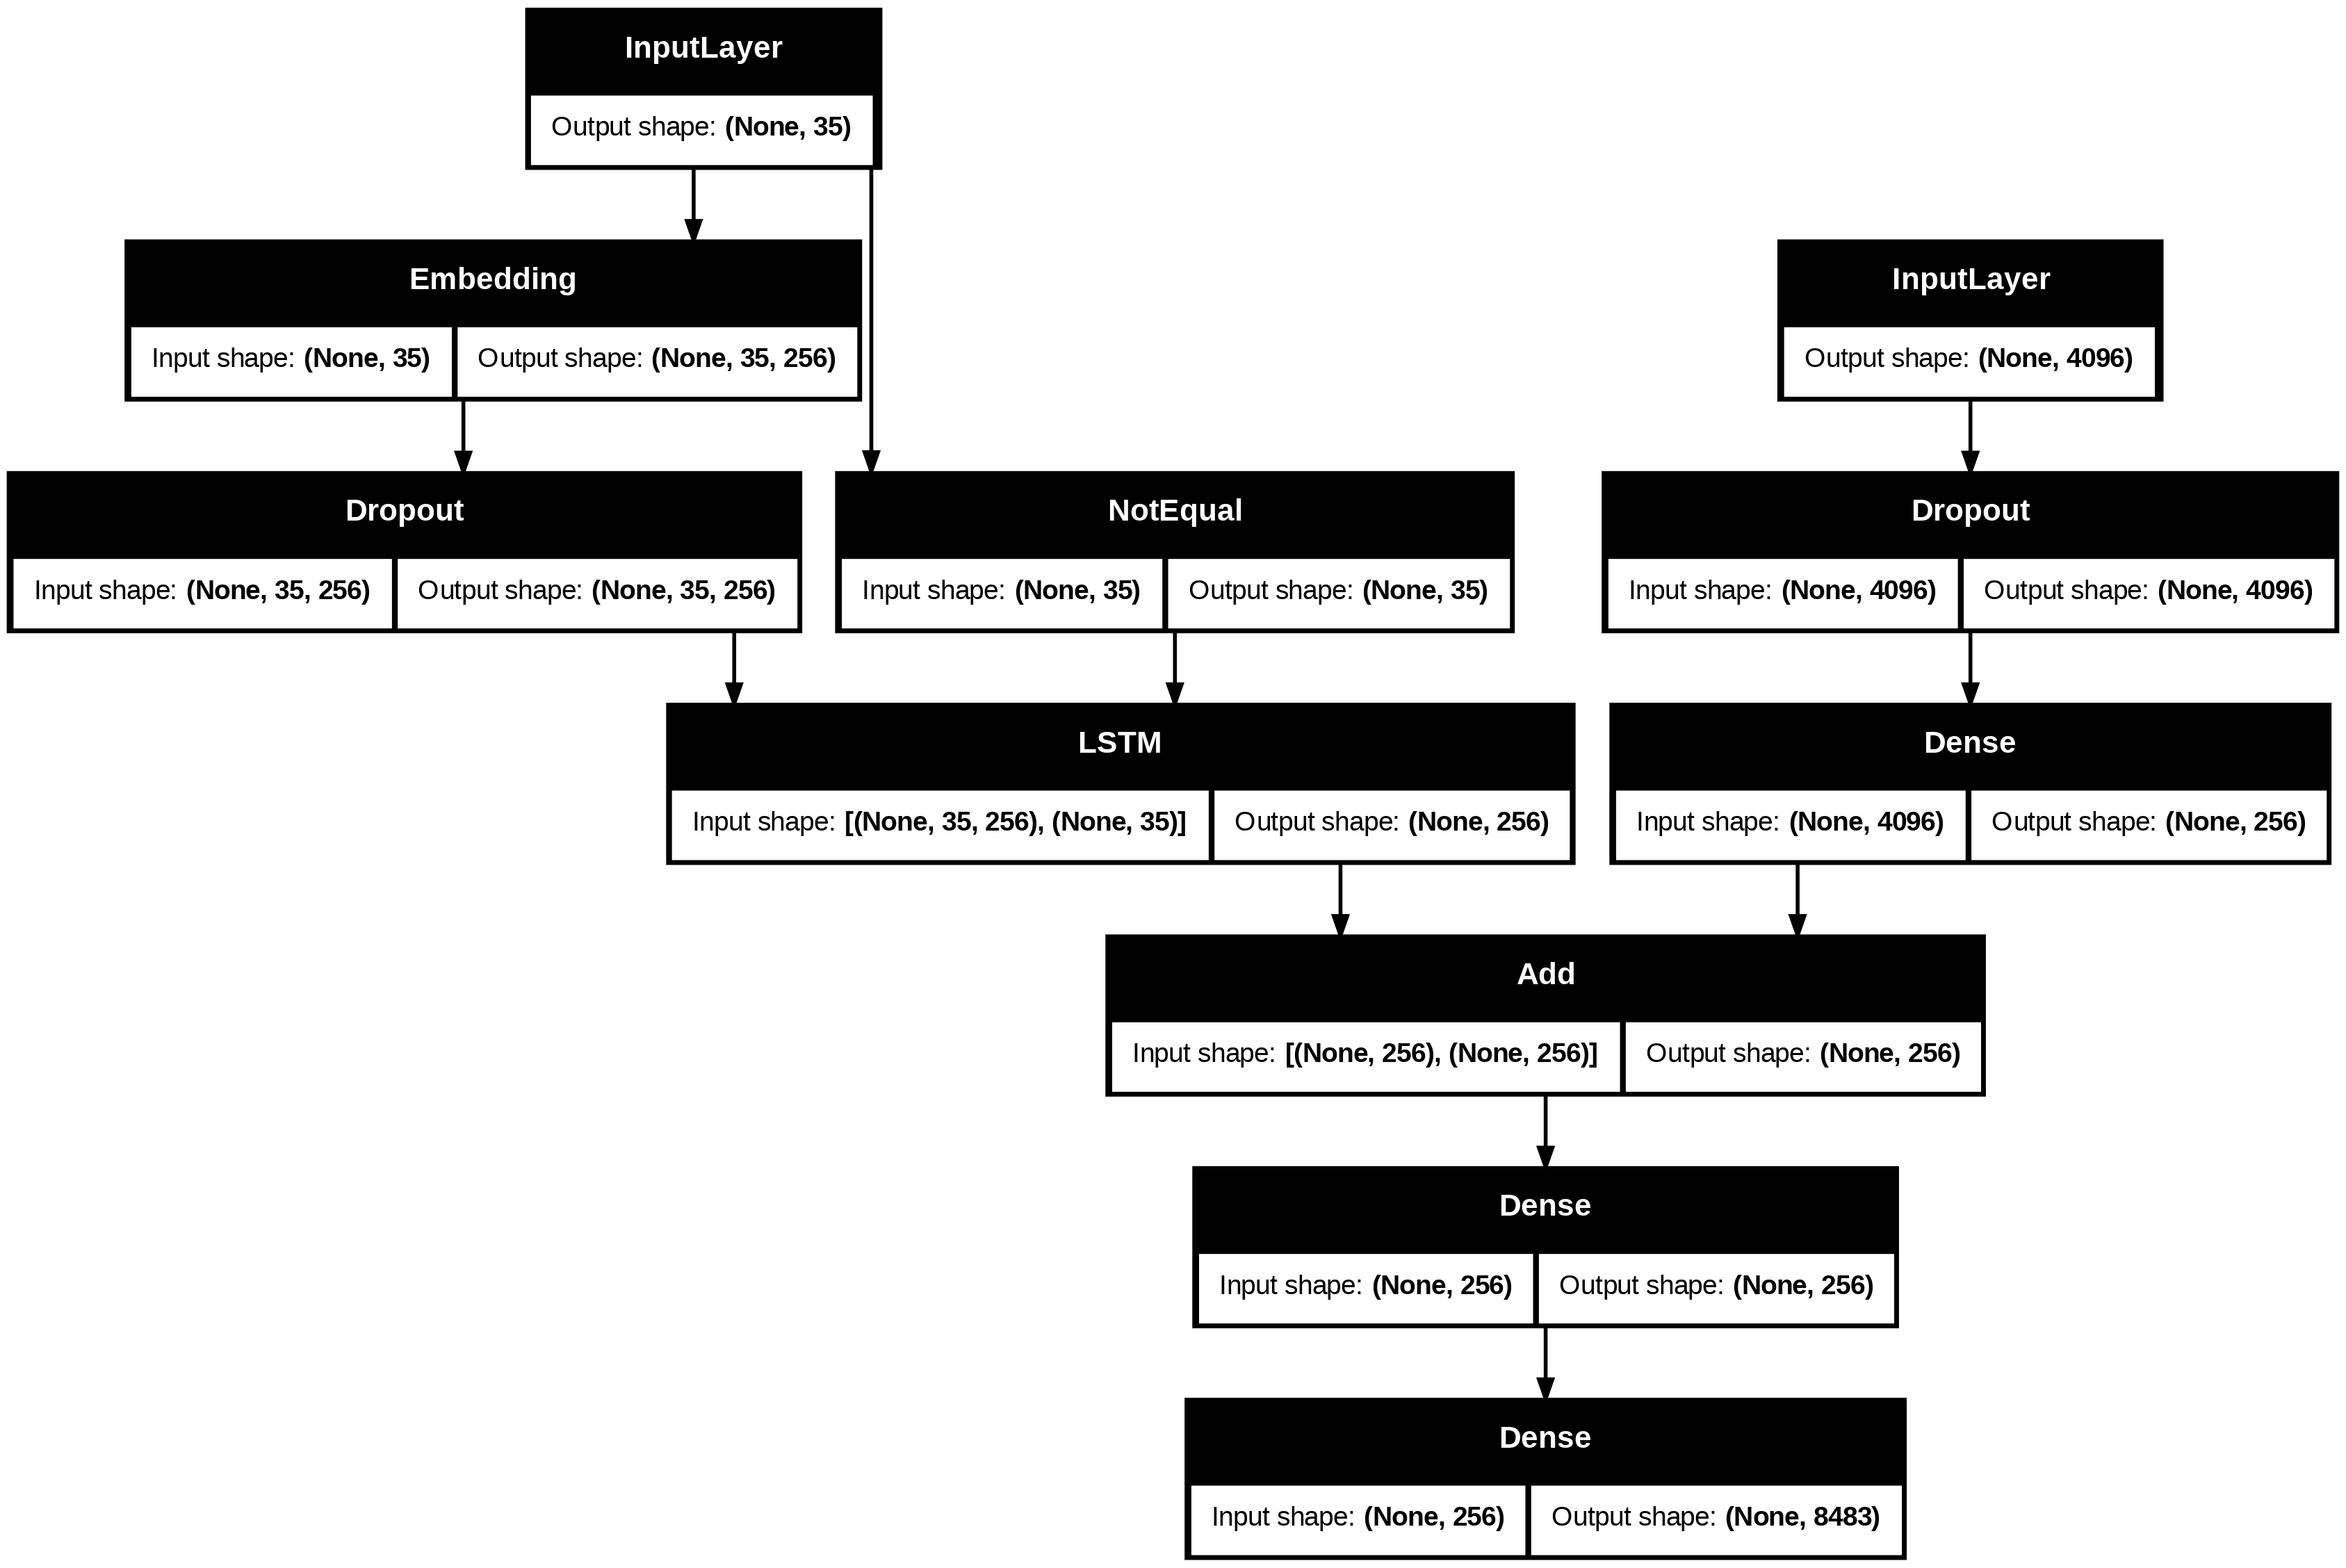

In [22]:
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation = 'relu')(fe1)

inputs2 = Input(shape=(max_length,), name = "text")
se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2,se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs = outputs)
model.compile(loss = "categorical_crossentropy", optimizer = 'adam')

plot_model(model, show_shapes = True)

In [23]:
epochs = 15
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


113/113 ━━━━━━━━━━━━━━━━━━━━ 60s 498ms/step - loss: 6.1775
113/113 ━━━━━━━━━━━━━━━━━━━━ 55s 483ms/step - loss: 4.4865
113/113 ━━━━━━━━━━━━━━━━━━━━ 56s 491ms/step - loss: 3.8033
113/113 ━━━━━━━━━━━━━━━━━━━━ 56s 498ms/step - loss: 3.4903
113/113 ━━━━━━━━━━━━━━━━━━━━ 55s 491ms/step - loss: 3.2808
113/113 ━━━━━━━━━━━━━━━━━━━━ 56s 492ms/step - loss: 3.1219
113/113 ━━━━━━━━━━━━━━━━━━━━ 56s 492ms/step - loss: 2.9975
113/113 ━━━━━━━━━━━━━━━━━━━━ 55s 490ms/step - loss: 2.8871
113/113 ━━━━━━━━━━━━━━━━━━━━ 55s 489ms/step - loss: 2.7909
113/113 ━━━━━━━━━━━━━━━━━━━━ 55s 487ms/step - loss: 2.7130
113/113 ━━━━━━━━━━━━━━━━━━━━ 55s 489ms/step - loss: 2.6464
113/113 ━━━━━━━━━━━━━━━━━━━━ 56s 497ms/step - loss: 2.5880
113/113 ━━━━━━━━━━━━━━━━━━━━ 56s 491ms/step - loss: 2.5345
113/113 ━━━━━━━━━━━━━━━━━━━━ 55s 491ms/step - loss: 2.4871
113/113 ━━━━━━━━━━━━━━━━━━━━ 54s 475ms/step - loss: 2.4451


In [24]:
model.save(WORKING_DIR+'/best_model.h5')

In [25]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [26]:
def predict_caption(model, image, tokenizer,max_length):
    in_text = '<start>'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],max_length,padding = 'post')
        yhat = model.predict([image,sequence],verbose = 0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break

        in_text += " " + word
        if word == '<end>':
            break
    return in_text


In [27]:

from nltk.translate.bleu_score import corpus_bleu
# validate with test data 
actual,predicted = list(),list()

for key in tqdm(test):
    captions = mapping[key]
    #predict the captions for image
    y_pred = predict_caption(model,features[key],tokenizer,max_length)
    #split into word
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    #append to list
    actual.append(actual_captions)
    predicted.append(y_pred)
    print("BLEU-1: %f" % corpus_bleu(actual,predicted,weights =(1.0,0,0,0)))
    print("BLEU-2: %f" % corpus_bleu(actual,predicted,weights =(0.5,0.5,0,0)))

  0%|          | 0/810 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.194444
BLEU-2: 0.074536


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.180556
BLEU-2: 0.101575
BLEU-1: 0.175926
BLEU-2: 0.100264
BLEU-1: 0.159722
BLEU-2: 0.082736
BLEU-1: 0.144444
BLEU-2: 0.070373
BLEU-1: 0.129630
BLEU-2: 0.060858
BLEU-1: 0.146825
BLEU-2: 0.081192
BLEU-1: 0.149306
BLEU-2: 0.086402
BLEU-1: 0.151235
BLEU-2: 0.087646
BLEU-1: 0.155556
BLEU-2: 0.096609
BLEU-1: 0.156566
BLEU-2: 0.094587
BLEU-1: 0.157407
BLEU-2: 0.092844
BLEU-1: 0.153846
BLEU-2: 0.091941
BLEU-1: 0.154762
BLEU-2: 0.088860
BLEU-1: 0.151852
BLEU-2: 0.086720
BLEU-1: 0.147569
BLEU-2: 0.082773
BLEU-1: 0.148693
BLEU-2: 0.082143
BLEU-1: 0.149691
BLEU-2: 0.085824
BLEU-1: 0.147661
BLEU-2: 0.082966
BLEU-1: 0.151389
BLEU-2: 0.088237
BLEU-1: 0.154762
BLEU-2: 0.088265
BLEU-1: 0.156566
BLEU-2: 0.091305
BLEU-1: 0.155797
BLEU-2: 0.092280
BLEU-1: 0.156250
BLEU-2: 0.092502
BLEU-1: 0.157778
BLEU-2: 0.096832
BLEU-1: 0.154915
BLEU-2: 0.094987
BLEU-1: 0.156379
BLEU-2: 0.093651
BLEU-1: 0.153770
BLEU-2: 0.091193
BLEU-1: 0.150383
BLEU-2: 0.088614
BLEU-1: 0.154630
BLEU-2: 0.091620
BLEU-1: 0.1559

Visualize the Results

In [28]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('-----------------Actual-----------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('-----------------Predicted-------------------')
    print(y_pred)
    plt.imshow(image)

-----------------Actual-----------------
<start> man in an orange hat starring at something <end>
<start> man wears an orange hat and glasses <end>
<start> man with gauges and glasses is wearing blitz hat <end>
<start> man with glasses is wearing beer can crocheted hat <end>
<start> the man with pierced ears is wearing glasses and an orange hat <end>
-----------------Predicted-------------------
<start> man wearing black hat is wearing blitz hat end end of beer end end end end end end end end end end end end end end end end end end end end end end end


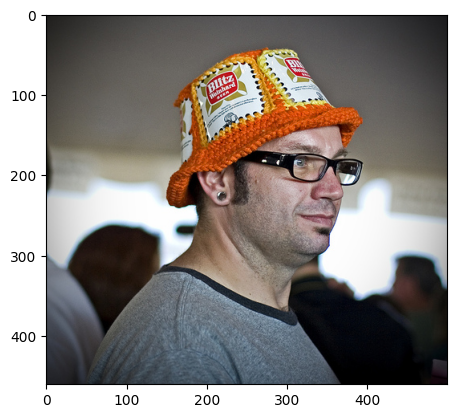

In [29]:
generate_caption('1007129816_e794419615.jpg')